# The Cleveland Heart Disease Dataset

A model to determine if an individual suffers from a heart ailment, or not.
0 - absent
1 - present.
If the individual does suffer from this ailment, the model tries to predict the severity of the disease:
1 - mild
2 - severe.

It does so through a hierarchical classification protocol.

Classifying diseased patients in stage one achieves a maximum accuracy of 90% and minimum accuracy of 83.33%.
Classifying the state of their disease achieves a modest maximum accuracy of 68%.

The combined model (presence + severity) evinced accuracies ranging from 65% to 82% - avg 73.5%.

### Developed by Pratham Shah (MIT Manipal, CSE '28 - 240905614), for the Cryptonite Research Taskphase.

In [1]:
RANDOM_STATE = 42
DEBUG = True
selector = "accuracy" #important assumption: for heart disease, its okay to have false positives

DEBUG = True will direct the model to find the best model by itself, using accuracy scores. If False, the model will use the default ML model I found to be best in training (with Random Seed = 42). 

# Preprocessing, Splitting, Normalising

In [2]:
import pandas as pd

df = pd.read_csv("processed.cleveland.data")
df = df.copy()

df.replace("?", None, inplace=True)
df.dropna(inplace=True)

The dataset did not need much cleaning, just the removal of some ? and NaN values.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

nominal_features = ['cp', 'slope', 'thal']

X = df.drop(columns=["num"])
y = df['num']

numerical_features = [col for col in X.columns if col not in nominal_features]

preprocessor = ColumnTransformer( #onehotencode all categorical data, z-score normalise all numeric data
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ]
)

X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=RANDOM_STATE)

preprocessor.fit(X_train_pre) #fit and transformed on train, the same transformation applies to test

X_train = preprocessor.transform(X_train_pre)
X_test = preprocessor.transform(X_test_pre)


# Phase One - Detection of Heart Disease

Here I use stratified 5-fold cross validation that maintains class imbalance in its subsets.

The 5 models given below are parsed through a cross validator from these 5 folds, and the overall performance of the model is evaluated and displayed through various metrics.

The model with the best accuracy is chosen and used as the final model of phase one classification.

In [4]:
# 0 remains 0 and 1-4 (> 0) becomes 1 using boolean logic
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, max_depth= 9, min_samples_leaf= 3),
    "XG Boost": XGBClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accuracy_list = []
scoremetric = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models.items():
    
    print(name)
    
    scores = cross_validate(model, X_train, y_train_binary, scoring=scoremetric, cv=cv)
    
    accuracy_list.append(scores[f"test_{selector}"].mean()) #mean because it returns the score for each split

    for metric in scoremetric:
        print(f"{metric}: {scores[f'test_{metric}'].mean()}")
    print()

Logistic Regression
accuracy: 0.8354609929078014
precision: 0.8265113871635611
recall: 0.8177489177489177
f1: 0.8167853404998848
roc_auc: 0.9064508824508826

Neural Network
accuracy: 0.7808510638297872
precision: 0.7620950888192267
recall: 0.7718614718614718
f1: 0.7599446640316205
roc_auc: 0.8761578421578422

SVM
accuracy: 0.797340425531915
precision: 0.7779316770186335
recall: 0.7891774891774892
f1: 0.7805393369619
roc_auc: 0.8757016317016317

Random Forest
accuracy: 0.8017730496453902
precision: 0.8124148315452663
recall: 0.7528138528138528
f1: 0.7765099137192161
roc_auc: 0.8874885114885116

XG Boost
accuracy: 0.7680851063829788
precision: 0.7575248265591515
recall: 0.7346320346320345
f1: 0.742591322980975
roc_auc: 0.8645680985680985



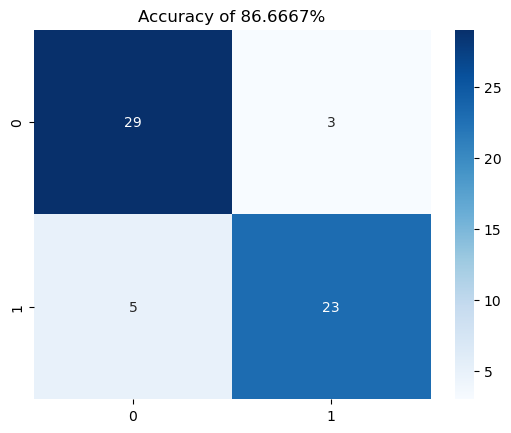

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

index = accuracy_list.index(max(accuracy_list)) #max accuracy model

if not DEBUG:
    index = 0 #defaults to logistic regression

final_model_one = list(models.values())[index]

final_model_one.fit(X_train, y_train_binary)

preds = final_model_one.predict(X_test)
cm = confusion_matrix(y_test_binary, preds)

plt.title(f"Accuracy of {(accuracy_score(y_test_binary, preds) * 100):.4f}%")

sns.heatmap(cm, annot=True,cmap="Blues")

plt.show()

print(classification_report(y_test_binary, preds))

Now, we can say with the above accuracy, whether an individual has a heart ailment.

# Phase Two - Finding Severity, Given Detection

Notice the severe class imbalance. Thus I have used SMOTE + EEN to upsample the underrepresented class later

num
0    160
1     54
3     35
2     35
4     13
Name: count, dtype: int64


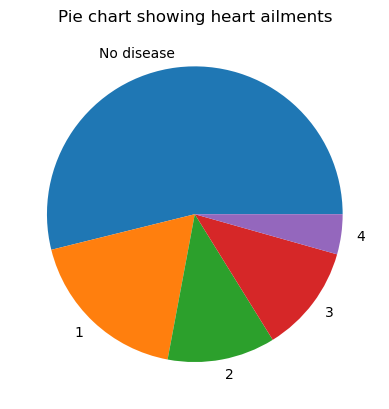

In [7]:
plt.title("Pie chart showing heart ailments")

vals = y_train.value_counts()+y_test.value_counts()

print(vals)

plt.pie(vals, labels=["No disease", 1, 2, 3, 4])
plt.show()

We've already dealt with classifying non-disease and diseased patients with decent accuracy. Now, we will attempt to classify the severity of such a heart disease, from a scale of 1-4.

In [8]:
X_disease = X[df["num"]>0]
y_disease = y[df["num"]>0]

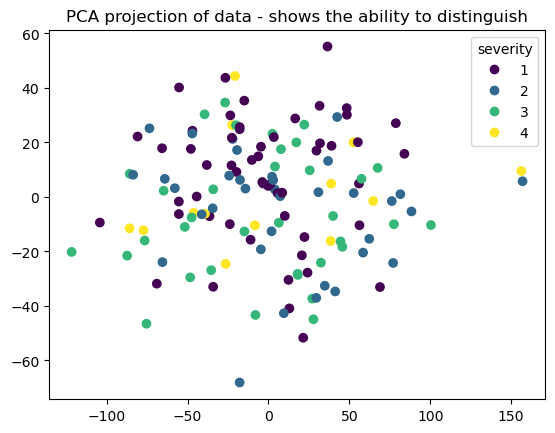

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_disease)

scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_disease) #the 2 components on each axis

plt.legend(*scatter.legend_elements(), title="severity") #argument unpacking

plt.title("PCA projection of data - shows the ability to distinguish")
plt.show()


The above graph proves that the data is heavily overlapping, with virtually no distinguishable class boundaries. 

SMOTE doesn't have enough stuff to impute towards, and thus cannot meaningfully contribute to class balancing.

I will now try to combine features: 1 can be mild, and 2, 3 and 4 can be severe heart disease. This appears to be the only way to make more meaningful predictions.

In [10]:
y_disease[y_disease.isin([2, 3, 4])] = 2

print("Severity Label Distribution:")
print(y_disease.value_counts())

Severity Label Distribution:
num
2    83
1    54
Name: count, dtype: int64


In [11]:
Xd_train_pre, Xd_test_pre, yd_train, yd_test = train_test_split(
    X_disease, y_disease, train_size=0.8, stratify=y_disease, random_state=RANDOM_STATE
)

preprocessor.fit(Xd_train_pre) #splitting and scaling for diseased
Xd_train = preprocessor.transform(Xd_train_pre)
Xd_test = preprocessor.transform(Xd_test_pre)

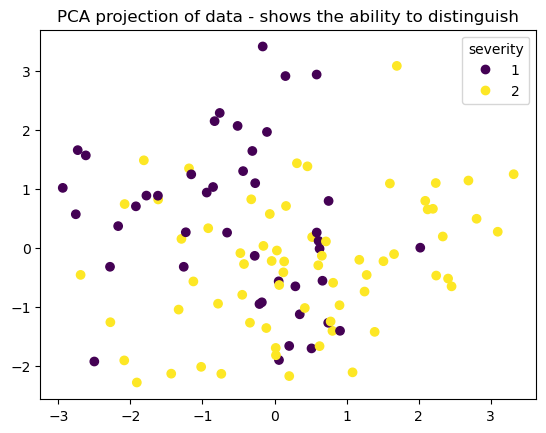

In [12]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(Xd_train)

scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=yd_train)

plt.legend(*scatter.legend_elements(), title="severity")
plt.title("PCA projection of data - shows the ability to distinguish")
plt.show()

#we can see now that the data is separable to a great extent

It's more distinguishable now: we can see 2 predominantly on the bottom left and centre right, and 1 on the top left and centre. Hopefully, any of the below models will do well on classifying this.

In [13]:
from imblearn.combine import SMOTEENN

smote = SMOTEENN(random_state=RANDOM_STATE)
Xd_train_res, yd_train_res = smote.fit_resample(Xd_train, yd_train)

for more redundancy given RANDOM_STATE change:

The same process derived from phase one's model selection is used here. Defaults to Neural Net.

In [14]:
from sklearn.tree import DecisionTreeClassifier

models2 = {
    "Neural Network" : MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    "SVM": SVC(class_weight='balanced', random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE, max_depth=6, min_samples_leaf=5),
}

accuracy_list2 = []

for name, model in models2.items():
    
    print(name)
    
    scores = cross_validate(model, Xd_train_res, yd_train_res, scoring=scoremetric, cv=cv)
    
    accuracy_list2.append(scores[f"test_{selector}"].mean())

    for metric in scoremetric:
        print(f"{metric}: {scores[f'test_{metric}'].mean()}")
    print()

index2 = accuracy_list2.index(max(accuracy_list2))

if not DEBUG:
    index2 = 0

final_model_two = list(models2.values())[index2]

print("FINAL MODEL 2 : " + list(models2.keys())[index2])

final_model_two.fit(Xd_train_res, yd_train_res)
y_pred2 = final_model_two.predict(Xd_test)
print(classification_report(yd_test, y_pred2))
    

Neural Network
accuracy: 0.9142857142857143
precision: 0.9266666666666667
recall: 0.96
f1: 0.9373737373737374
roc_auc: 1.0

Random Forest
accuracy: 0.9142857142857143
precision: 0.9266666666666665
recall: 0.96
f1: 0.9418181818181818
roc_auc: 0.9800000000000001

Logistic Regression
accuracy: 0.9714285714285715
precision: 1.0
recall: 0.96
f1: 0.9777777777777779
roc_auc: 1.0

SVM
accuracy: 0.9428571428571428
precision: 0.96
recall: 0.96
f1: 0.9555555555555555
roc_auc: 1.0

Decision Tree
accuracy: 0.7821428571428571
precision: 0.86
recall: 0.78
f1: 0.8155555555555555
roc_auc: 0.7733333333333333

FINAL MODEL 2 : Logistic Regression
              precision    recall  f1-score   support

           1       0.56      0.91      0.69        11
           2       0.90      0.53      0.67        17

    accuracy                           0.68        28
   macro avg       0.73      0.72      0.68        28
weighted avg       0.76      0.68      0.68        28



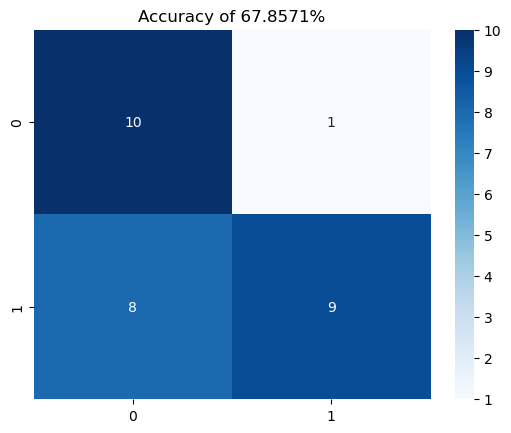

In [15]:
cm = confusion_matrix(yd_test, y_pred2)

plt.title(f"Accuracy of {(accuracy_score(yd_test, y_pred2) * 100):.4f}%")

sns.heatmap(cm, annot=True,cmap="Blues")

plt.show()

# Conclusion by Combining Both Models:

The entire testing set is predicted as 0 and 1 first for phase one, and then all the 1s (diseased) are further isolated, their severity predicted by phase two, and replaced by severity levels outputed by phase two (1/2).

This gives the testing set a range of 0-2.

In [16]:
import numpy as np

def predict (X_test, y_test):
    predictions1 = final_model_one.predict(X_test)

    diseased_indices = np.where(predictions1 == 1)[0]
    diseased = X_test[diseased_indices]

    predictions2 = final_model_two.predict(diseased)

    final_predictions = np.zeros_like(predictions1)  # all start as 0 again, predictions2 filled in on 1s indexes

    final_predictions[diseased_indices] = predictions2

    y_test[y_test > 2] = 2

    print(classification_report(y_test, final_predictions))
    
    return final_predictions

print(predict(X_test, y_test))


              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.62      0.45      0.53        11
           2       0.83      0.88      0.86        17

    accuracy                           0.82        60
   macro avg       0.77      0.75      0.75        60
weighted avg       0.81      0.82      0.81        60

[0 0 0 0 0 0 0 0 2 0 2 0 0 2 2 2 1 0 1 2 1 0 1 2 2 0 0 2 0 2 0 2 2 0 0 2 0
 2 0 0 0 2 1 1 0 0 1 0 2 0 0 0 0 0 2 0 2 0 1 0]


The model thus is predicting heart disease to an agreeable accuracy. This solves the problem posed by the dataset.